In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!cp '/content/drive/MyDrive/magna/step5/selftrainingloss.py' './selftrainingloss.py'
!cp '/content/drive/MyDrive/magna/step5/client.py' './client.py'
!cp '/content/drive/MyDrive/magna/step5/server.py' './server.py'
!cp '/content/drive/MyDrive/dataset.py' './dataset.py'
!cp '/content/drive/MyDrive/bisenetv2.py' './bisenetv2.py'
!cp '/content/drive/MyDrive/transform.py' './transform.py'
!cp '/content/drive/MyDrive/style.py' './style.py'

Mounted at /content/drive


In [ ]:
import torchvision
from sklearn.metrics import confusion_matrix  
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import VisionDataset
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import os.path
import sys
from torch.backends import cudnn
import numpy as np
import matplotlib.pyplot as plt

from dataset import Cityscapes
from client import *
from server import *
from bisenetv2 import *
from transform import *
from selftrainingloss import *

In [ ]:
#DEVICE = 'cuda' # 'cuda' or 'cpu'
DEVICE = 'cuda'
NUM_CLASSES = 19 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 16     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 5*1e-3           # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default -5

NUM_EPOCHS = 25      # 20/30 Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       #20 How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

In [ ]:
#transformations
size = (256, 512) #512,1024
scales=(0.25, 2.)
cropsize=(512, 1024)
eval_crop=(1024, 1024)
eval_scales=(0.5, 0.75, 1.0, 1.25, 1.5, 1.75)
test_transformations = [RandomResizedCrop(eval_scales, eval_crop)]
train_transformations = [RandomResizedCrop(scales,cropsize),RandomHorizontalFlip(),ColorJitter(brightness=0.4,contrast=0.4,saturation=0.4)]
test_transformations = Compose(test_transformations)
train_transformations = Compose(train_transformations)

In [ ]:

clients = []
datasets = []
with open("/content/drive/MyDrive/data/data/Cityscapes/train_B_II.txt") as lines:
  curr_id = 0
  paths = []
  for line in lines:
    id_client,path = line.split(" ")
    if curr_id == int(id_client):
      paths.append(path)
    else:
      print(f"finished Client ID:[{curr_id}]: len: {len(paths)}")
      dataset = DatasetClient("/content/drive/MyDrive/data/data/Cityscapes",paths,train_transformations)
      datasets.append(dataset)
      client = Client(curr_id,dataset,pseudo_lab=True)
      clients.append(client)

      paths = []
      paths.append(path)
      curr_id = int(id_client)  

  dataset = DatasetClient("/content/drive/MyDrive/data/data/Cityscapes",paths,train_transformations)
  datasets.append(dataset)
  client = Client(curr_id,dataset,pseudo_lab=True)
  clients.append(client)

#print(len(clients), f"last: {curr_id}")

finished Client ID:[0]: len: 20
finished Client ID:[1]: len: 20
finished Client ID:[2]: len: 20
finished Client ID:[3]: len: 8
finished Client ID:[4]: len: 19
finished Client ID:[5]: len: 20
finished Client ID:[6]: len: 13
finished Client ID:[7]: len: 20
finished Client ID:[8]: len: 1
finished Client ID:[9]: len: 20
finished Client ID:[10]: len: 13
finished Client ID:[11]: len: 20
finished Client ID:[12]: len: 20
finished Client ID:[13]: len: 8
finished Client ID:[14]: len: 14
finished Client ID:[15]: len: 19
finished Client ID:[16]: len: 20
finished Client ID:[17]: len: 10
finished Client ID:[18]: len: 13
finished Client ID:[19]: len: 20
finished Client ID:[20]: len: 20
finished Client ID:[21]: len: 15
finished Client ID:[22]: len: 20
finished Client ID:[23]: len: 3
finished Client ID:[24]: len: 20
finished Client ID:[25]: len: 5
finished Client ID:[26]: len: 20
finished Client ID:[27]: len: 4
finished Client ID:[28]: len: 20
finished Client ID:[29]: len: 14
finished Client ID:[30]: l

In [ ]:
test_dataset_B = Cityscapes('/content/drive/MyDrive/data/data/Cityscapes',transform=None,split='val')
test_dataset_A = Cityscapes('/content/drive/MyDrive/data/data/Cityscapes',transform=None,split='valA')

In [ ]:
test_dataloader_B = DataLoader(test_dataset_B, batch_size=1, shuffle=False, num_workers=2,drop_last=True)
test_dataloader_A = DataLoader(test_dataset_A, batch_size=1, shuffle=False, num_workers=2,drop_last=True)

In [ ]:
model_path = "/content/drive/MyDrive/magna/step5/FDA/Dataset_B_II/pretrained_model/10checkpoint.pt"
checkpoint = torch.load(model_path)

server = Server(clients, checkpoint['model_state_dict'],test_dataloader_B,pseudo_lab=True)

server.train()



In [ ]:
bisenet_model = BiSeNetV2(n_classes=19,output_aux=True,pretrained=True)
criterion = nn.CrossEntropyLoss(ignore_index=255,reduction='none')

Downloading: "https://github.com/CoinCheung/BiSeNet/releases/download/0.0.0/backbone_v2.pth" to /root/.cache/torch/hub/checkpoints/backbone_v2.pth


  0%|          | 0.00/8.34M [00:00<?, ?B/s]

In [ ]:
def _fast_hist(n_classes, label_true, label_pred):
      mask = (label_true >= 0) & (label_true < n_classes)
      hist = np.bincount(
          n_classes * label_true[mask].astype(int) + label_pred[mask],
          minlength=n_classes ** 2,
      ).reshape(n_classes, n_classes)
      return hist


def compute_mIoU(y_true,y_pred):
  
  y_pred = y_pred.cpu().numpy().flatten()
  y_true = y_true.cpu().numpy().flatten()
  # print(y_true)
  # print(y_pred)
  # index = [i for i in range(len(y_true)) if y_true[i] != 255]
  # mask = y_true == 255
  # y_true = np.delete(y_true, np.where(mask))
  # y_pred = np.delete(y_pred, np.where(mask))
  #print(index)
  # print(y_true)
  # print(y_pred)
  #hist = confusion_matrix(y_true, y_pred, labels=range(19))
  hist = _fast_hist(19,y_true,y_pred)
  #print(hist)
  gt_sum = hist.sum(axis=1)
  mask = (gt_sum != 0)
  diag = np.diag(hist)
  iu = diag / (gt_sum + hist.sum(axis=0) - diag)
  mean_iu = np.mean(iu[mask])
  return mean_iu

In [ ]:
from torchvision import ops
from tqdm import tqdm
def mIoU_test_dataset(dataloader):
  net = bisenet_model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  net=net.half()
  running_corrects = 0
  torch.cuda.empty_cache() 
  IoU = 0
  count = 0
  for images, labels in tqdm(dataloader):
    images = images.half().to(DEVICE)
    labels = labels.half().to(DEVICE)
    # print(images.size())
    # print(labels.size())
    # Forward Pass
    outputs = net(images,test=True,use_test_resize=False)
    # output1,output2,output3,output4,output5 = net(images,test=False,use_test_resize=False)
    preds = outputs.argmax(dim=1)

    loss = criterion(outputs,labels.long())[labels!=255].mean()


    # loss1 = criterion(output1,labels.long())[labels!=255].mean()
    # loss2 = criterion(output2,labels.long())[labels!=255].mean()
    # loss3 = criterion(output3,labels.long())[labels!=255].mean()
    # loss4 = criterion(output4,labels.long())[labels!=255].mean()
    # loss5 = criterion(output5,labels.long())[labels!=255].mean()

    # loss = loss1+loss2+loss3+loss4+loss5

    # print(outputs.size())
    #print(preds.size())
    #print(compute_IoU(labels,preds,NUM_CLASSES))
    #IoU += compute_mIoU(labels,preds,NUM_CLASSES)
    #print(prova(labels,preds))
    IoU += compute_mIoU(labels,preds)
    #print(count)
    #count += BATCH_SIZE//4
    count += 1
    # iou = ops.box_iou(labels, outputs)

    # print('IOU : ', iou.numpy()[0][0])
  #print("iou:",IoU,"count:",count)
  print("mIoU = ",IoU/count,"loss=",loss.item())
  return IoU/count,loss.item()

In [ ]:
# mIoU_test_for_epochs_A = []
# loss_test_for_epochs_A = []
# mIoU_test_for_epochs_B = []
# loss_test_for_epochs_B = []
mIoU_test_for_epochs = []
loss_test_for_epochs = []
for i in range(0,110,10):
  print("checkpoint:",i)
  checkpoint = torch.load('/content/drive/MyDrive/magna/step5/NO_FDA/DatasetB_II/checkpoints/TN/' +str(i)+'checkpoint.pt')
  bisenet_model.load_state_dict(checkpoint['model_state_dict'])
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  # optimizer = optim.SGD(bisenet_model.parameters(), lr=1*1e-4, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
  bisenet_model.to(DEVICE)
  # check_epoch = checkpoint['epoch']
  # check_loss = checkpoint['loss']
  #loss_for_epochs = checkpoint['loss_for_epochs']
  #mIoU_for_epochs = checkpoint['mIoU_for_epochs']
  mIoU,loss = mIoU_test_dataset(test_dataloader_B)
  mIoU_test_for_epochs.append(mIoU)
  loss_test_for_epochs.append(loss)
  # mIoU,loss = mIoU_test_dataset(test_dataloader_A)
  # mIoU_test_for_epochs_A.append(mIoU)
  # loss_test_for_epochs_A.append(loss)
  # mIoU,loss = mIoU_test_dataset(train_dataloader_B)
  # mIoU_train_for_epochs.append(mIoU)
  # loss_train_for_epochs.append(loss)

print(mIoU_test_for_epochs)
print(loss_test_for_epochs)
# print(loss_test_for_epochs_B)
# print(mIoU_test_for_epochs_B)
#plotLoss(loss_test_for_epochs,'test_loss')
#plotmIoU(mIoU_test_for_epochs,'test_mIoU')
# plotLoss(loss_train_for_epochs,'train_loss')
# plotmIoU(mIoU_train_for_epochs,'train_mIoU')

In [ ]:
LEN = 20
def plotLoss(train,label):
  epochs = np.array([a*10 for a in range(LEN)]).reshape(LEN,1)
  plt.figure()
  #plt.plot(epochs,val,label='val_loss')
  plt.ylim(0,max(train)+1)
  plt.plot(epochs,train,label=label)
  plt.legend()
  plt.show()

def plotmIoU(train,label):
  epochs = np.array([a*5 for a in range(LEN)]).reshape(LEN,1)
  plt.figure()
  #plt.plot(epochs,val,label='val_loss')
  plt.ylim(0,max(train)+0.01)
  plt.plot(epochs,train,label=label)
  plt.legend()
  plt.show()

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/magna/step5/NO_FDA/DatasetA_II/checkpoints/TN/100checkpoint.pt')
mIoU_for_rounds = checkpoint['mIoU_for_rounds']
loss_train = checkpoint['loss_train']
loss_train_print = []
print(loss_train)
print(len(loss_train))
for i in range(len(loss_train)):
  if loss_train[i] != []:
    loss_train_print.append(loss_train[i][0])
print(loss_train_print)

[[9.0703125, 9.041666666666666], [8.921875, 8.91796875], [8.73125, 8.7046875], [8.515625, 8.515625], [8.334375, 8.3203125], [8.065625, 8.0390625], [7.876953125, 7.87109375], [7.68125, 7.6296875], [7.505859375, 7.466796875], [], [7.2125, 7.18515625], [7.03125, 7.03125], [6.81484375, 6.759375], [6.64453125, 6.5859375], [6.4140625, 6.44140625], [6.193359375, 6.1865234375], [], [5.8046875, 5.8984375], [5.64375, 5.640625], [5.5140625, 5.48828125], [5.3703125, 5.3625], [5.203125, 5.197265625]]
22
[9.0703125, 8.921875, 8.73125, 8.515625, 8.334375, 8.065625, 7.876953125, 7.68125, 7.505859375, 7.2125, 7.03125, 6.81484375, 6.64453125, 6.4140625, 6.193359375, 5.8046875, 5.64375, 5.5140625, 5.3703125, 5.203125]


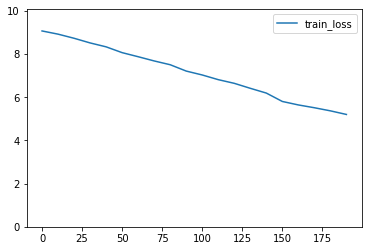

In [ ]:
#plotmIoU(mIoU_for_rounds,'test_mIoU')
plotLoss(loss_train_print,'train_loss')

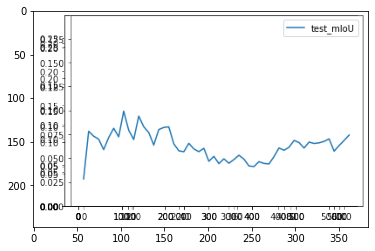

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()# read the first plot
img1 = plt.imread("/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_A_II_0.005/mIoU_long_esp_3_dataset_A_II_test.png")# read the second plot
img2 = plt.imread("/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_A_I_0.005/mIoU_long_esp_3_dataset_A_I_test.png")# read the third plot
img3 = plt.imread("/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_A_I_0.05/mIoU_long_esp_dataset_A_I_step3_0.05.png")# plot the first image
img4 = plt.imread("/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_B_II_0.005/mIoU_long_esp_3_dataset_B_II_test.png")
img5 = plt.imread("/content/drive/MyDrive/magna/step3/checkpoint/long_esp_dataset_B_I_0.005/mIoU_long_esp_3_dataset_B_I_test.png")
ax.imshow(img1)# plot the second image
ax.imshow(img2)# plot the third image
ax.imshow(img3)
ax.imshow(img4)
ax.imshow(img5)
plt.show()
#plt.savefig('plot_new.png')